# Embedded ML Lab - Excercise 3 - Pruning

Now we will focus on structured pruning to save computation time. We will do this in three steps.  
* We will implement a function, similar to previous l1 pruning, to sets whole output channels to zero.  

* We will delete the zeroed-out channels and densify the network again to have a reduction in computation time.

* We will retrain the network to gain accuracy again.  



In [1]:
import torch
torch.rand(1).to('mps') #initialize cuda context (might take a while)

from net import PrunedCifarNet
import torch
from typing import Dict, List
import numpy as np

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=False, download=True, transform=tf), shuffle=False, batch_size=32)
trainloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=True, download=True, transform=tf), shuffle=True, batch_size=32)

First, we focus on setting the output channels to zero.  
Your Task:
   * Implement the function `l1_structured_pruning`, that takes a `state_dict` and a `prune_ratio` as input. Calculate the l1 norm $||x||_1= \sum_{i=1}^N |x_i|$, of each output channel, and set the output channels with the lowest norm to zero to meet the prune_ratio.
       * Also, for each output channels that is zeroed-out, set the convolution's bias to zero
       * You can keep `conv1` and `conv2` unpruned.

In [34]:
def l1_structured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    
    #-to-be-done-by-student------
    norms = []
    for i in range (3,7):
        # out channel i
        w = state_dict[f"conv{i}.weight"]
        out_channels = w.size(0) #(out_channels, in_channels, kernel_height, kernel_width)
        k = int(prune_ratio * out_channels) # k channels prunen -> Die k kleinsten L1 normen
        if k == 0:
            continue
        
        l1_norm = torch.sum(torch.abs(w), dim=(1,2,3))  # Calculate L1 norm for each output channel dim 1 = in_channel, dim 2 = kernel_height, dim 3 = kernel_width
        
        _, idx = torch.topk(l1_norm, k, largest=False)


        w[idx] = 0
        state_dict[f"conv{i}.weight"] = w
        
        #bias to zero
        state_dict[f"conv{i}.bias"][idx] = 0
        
    #----------------------------
    return state_dict

We now iteratively test the function for several pruning ratios. Right now, we get no gains in MACs (Multiply-accumulate operations), since the values are just set to zero.

100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


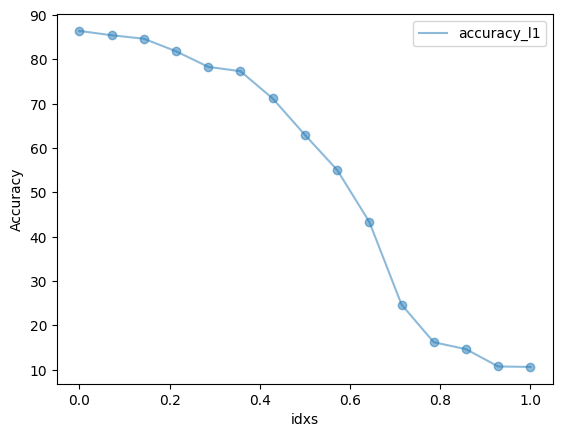

In [35]:
import tqdm
import copy

from utils import net_acc, net_time, net_macs, plot

ratios = np.linspace(0, 0.8, 15)

state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_l1, idxs = [], []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    state_dict = l1_structured_pruning(state_dict, ratio)
    accuracy_l1.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='mps'))
    idxs.append(idx)
plot([(idxs, accuracy_l1, 'accuracy_l1')], xlabel='idxs', save_path='accuracy_l1.png')

Next, we implement a function that removes the zeroed-out output channels to gain actual inference speed ups.

Your Tasks:
* For each `weight` tensor of conv2d layers, slice the tensor such that only the output channels with non-zero filters remain.
* If an output channel is removed, also remove its respective bias.
* For each consecutive conv layer, remove the input channels that are zeroed-out output channels of the previous conv layer   
* TIP: A tensor containing channels can be reshaped using a list of indices (e.g., `new_tensor = tensor[[1,2,3,5,6,7],:,:,:]` 
* For the last conv2d layer, you have to consider the flattened  output and slice the input of the fully connected layer. In the case of the `CifarNet` we currently use, the feature map before being flatted is $2\times 2$ with $256$ output channels, where `torch.flatten` arranges the channels starting with index $0$.

As a help, check the image: Each pruned output filter (gray/vertical) appears as a pruned input (red/horizontal) in the consecutive conv layer.  
<img src="src/prune.png" alt="drawing" width="700"/>

In [38]:
def densify_state_dict(state_dict: Dict) -> Dict:
    state_dict = copy.deepcopy(state_dict)

    num_convs = 6  
    last_conv_keep_idx = None

    for i in range(1, num_convs + 1):
        w_key = f"conv{i}.weight"
        b_key = f"conv{i}.bias"

        w = state_dict[w_key]  # (out_channels, in_channels, kH, kW)
        b = state_dict[b_key]  # (out_channels,)

        out_channels = w.size(0)

        keep_idx = []
        for ch in range(out_channels):
            if w[ch].abs().sum() != 0:
                keep_idx.append(ch)

        if len(keep_idx) == 0:
            keep_idx = [0]

        w = w[keep_idx, :, :, :]
        b = b[keep_idx]

        state_dict[w_key] = w
        state_dict[b_key] = b

        if i < num_convs:
            next_w_key = f"conv{i+1}.weight"
            next_w = state_dict[next_w_key]  # (next_out_channels, in_channels, kH, kW)

            # zweite Dimension = in_channels -> entsprechend keep_idx slicen
            next_w = next_w[:, keep_idx, :, :]
            state_dict[next_w_key] = next_w
        else:
            last_conv_keep_idx = keep_idx

    # FC-Eingänge nach conv6 anpassen (Featuremap 2x2)
    if last_conv_keep_idx is not None:
        fc_key = "fc.weight"
        fc_w = state_dict[fc_key]  # (num_classes, 256*2*2 

        H = 2
        W = 2
        hw = H * W  # = 4

        fc_indices = []
        for ch in last_conv_keep_idx:
            start = ch * hw
            end = start + hw
            fc_indices.extend(range(start, end))

        fc_w = fc_w[:, fc_indices]
        state_dict[fc_key] = fc_w

    return state_dict

If you have implemented the `densify_state_dict` function correctly, the plot (orange) should behave exactly the same (orange and blue should overlap).

100%|██████████| 15/15 [00:04<00:00,  3.07it/s]


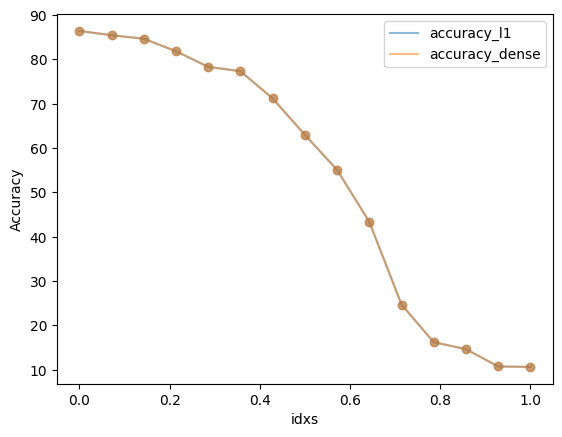

In [39]:
state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_dense = []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    state_dict = l1_structured_pruning(state_dict, ratio)
    sd = densify_state_dict(state_dict)
    accuracy_dense.append(net_acc(PrunedCifarNet, sd, testloader, batches=32, device='mps'))
plot([(idxs, accuracy_l1, 'accuracy_l1'), (idxs, accuracy_dense, 'accuracy_dense')], xlabel='idxs', save_path='accuracy_l1.png')

Now we implement the last missing pieces to apply iterative pruning. To save time, we only apply changes to the last linear layer, all other layers are frozen.

Your Tasks:
* Implement a training function that takes the `model_class` the `state_dict`, the `trainloader`, the number of batches, and device (cpu/cuda) as input and returns a state_dict as output.

In [42]:
def train(model_class: torch.nn.Module, state_dict: Dict,
          trainloader: torch.utils.data.DataLoader, batches: int=64, device: str='cpu'):

    # Learning rate
    lr = 0.01

    torch_device = torch.device(device)

    model = model_class()
    model.load_state_dict(state_dict)
    model.to(torch_device)

    model.train()
    
    # For all conv layers we disable the calculation of gradients in the backwards step
    for key, param in model.named_parameters():
        if any(x in key for x in ['1', '2', '3', '4', '5', '6']):
            param.requires_grad = False
    # The optimizer gets only the parameters that require gradient calculation
    optimizer = torch.optim.SGD(filter(lambda x: x.requires_grad, model.parameters()), lr=lr)
    
    # Loss function
    loss_f = torch.nn.CrossEntropyLoss()
    

    for idx, (inputs, targets) in enumerate(trainloader):
        
    #-to-be-done-by-student-----
        if idx >= batches:
            break
            
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_f(outputs, targets)
        loss.backward()
        optimizer.step()
    
    #---------------------------
    return model.state_dict()

We now iteratively prune some percent and retrain the densified state dict. We therefor use an adaptable `PrunedCifarNet` that changes the layer definition based on the parameters dimensions of the state dict.

Furthermore, we plot two versions: One with fine-tuned parameters, one where no re-training is applied.

100%|██████████| 26/26 [00:19<00:00,  1.31it/s]


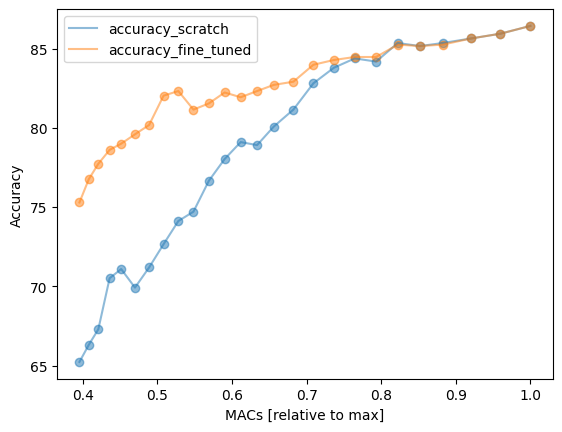

In [43]:
# define ratios
ratios = [0.0] + [0.025 for _ in range(25)]
state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_from_scratch, accuracy_fine_tuned, macs = [], [], []
for ratio in tqdm.tqdm(ratios):
    
    # Setting Filters to zero
    state_dict = l1_structured_pruning(state_dict, ratio)
    
    # Densifying the state dict
    state_dict = densify_state_dict(copy.deepcopy(state_dict))
    
    # Accuracy calculation
    accuracy_from_scratch.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='mps'))

#We now do the same with training for comparions (this might take a while)
state_dict = torch.load('state_dict__cifarnet.pt')
for ratio in tqdm.tqdm(ratios):
    state_dict = l1_structured_pruning(state_dict, ratio)
    state_dict = densify_state_dict(copy.deepcopy(state_dict))
    
    #We fine tune the network by training with 150 batches
    state_dict = train(PrunedCifarNet, state_dict, trainloader, batches=32, device='mps')
    accuracy_fine_tuned.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='mps'))
    macs.append(net_macs(PrunedCifarNet, state_dict))
    
    
plot([(macs, accuracy_from_scratch, 'accuracy_scratch'),
      (macs, accuracy_fine_tuned, 'accuracy_fine_tuned')],
      xlabel='MACs [relative to max]', save_path='accuracy_macs.png')